# OZ's report on Trained AI
_A nice monologuing banter about neural networks and NLP_

_by: OZ (Ollie Zi Feng Zheng) 44609620 advised by Diego Molla Aliod_

**Index**
1. Introduction [goto](#intro)
2. Data Discussion [goto](#data)
1. Explanations [goto](#explain)
1. Try it [goto](#try)
3. Algorithm [goto](#algorithm)
4. Discussion and Evaluation [goto](#discussion)

<a id='intro'></a>
## Introduction

Media has to be written in a style that is liked by their target audience in order to get a subscribing customer base. So we'd expect the news publisher, Vice News, to usually write in a style and subject that appeals to a younger bohemian reader base, on the other hand, Fox News would expectedly write in a style for older more conservative types.

Then ideally, we should therefore be able to come up with a framework about the type of vocabulary and subject matter that each publisher would be writing about.

For our project, we want to use Natural Language Processing AI (NLP) methods to be able to determine the variations between 15 different new publishers and predict the publisher of a given article based on the contents/words of that article.

This will all be done with a [kaggle dataset](https://www.kaggle.com/snapcrack/all-the-news) containing around 150,000 new articles, with only the article content being our primary predictor for publication source.

We'll mainly use [Keras](https://keras.io/), it's a very nice Python package for deep learning for learning purposes and can also be built on top of other deep learning packages such as TensorFlow or Theano.

<a id="data"></a>
## Data Discussion

Before we get ourselves knee deep into training some AI about the differences in sensationalist media, we should get ourselves acquainted with the data - like a carpenter gets acquainted with his wood.

We don't want to build a bed out of balsa wood and gyprock afterall. 

We want to take a little look at the tree rings of our data. Let's load our packages first.

In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder

import keras.backend as K
from keras.models import Sequential
from keras.layers import (Dense, Activation,
                          Flatten, Embedding, Dropout, Reshape, Lambda)
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer, text_to_word_sequence
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Append all csv files
df = pd.read_csv('data/news/articles1.csv')
df = df.append(pd.read_csv('data/news/articles2.csv'))
df = df.append(pd.read_csv('data/news/articles3.csv'))

# Shuffle
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Splitting
parts = {
    'train':int(len(df)*0.7), 
    'dev':int(len(df)*0.15)+1, 
    'test':int(len(df)*0.15)+1
}

# Split the data into features(X) and labels(y)
X = {key:None for key in list(parts.keys())}
y = {key:None for key in list(parts.keys())}

X['train'] = df['content'][:parts['train']]
X['dev'] = df['content'][parts['train']:parts['train']+parts['dev']]
X['test'] = df['content'][parts['train']+parts['dev']:]

y['train'] = df['publication'][:parts['train']]
y['dev'] = df['publication'][parts['train']:parts['train']+parts['dev']]
y['test'] = df['publication'][parts['train']+parts['dev']:]

#### Distributions of publishers

We have to do this because it may affect whether or not a machine will bias towards one class or not if the distribution of classes isn't uniformly distributed.

Text(0,0.5,'Count')

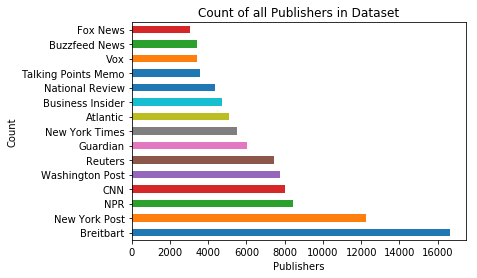

In [3]:
%matplotlib inline

counts = y['train'].value_counts() 
counts.plot.barh()
plt.title('Count of all Publishers in Dataset')
plt.xlabel('Publishers')
plt.ylabel('Count')

Visually there is a huge disparity between our max `Breitbart` and our min `Fox News` and it may affect our learning, it can be expected that our AI might not be able to properly identify posts from the publishers with less articles.

We might have to duplicate our minimum publishers with filler articles so that our classes can be uniformly distributed.

We'll now look at the word counts.

#### Average word counts throughout entire corpus

This has to be done because we must see if our articles are actually beefy enough and full of nutritious delicious information. The individual documents could actually just be bare bones for all we know.

I'll keep stopwords because I feel that some publishers may veer to certain strong pattern words. 

E.g. Propaganda in the olden days used `We` `Us` a lot, versus a modern legal document which may include no `We`s or `Us`s at all.

In [4]:
sum_ = 0
for article in X['train'][:3000]:
    re.sub(r'\W', '', article)
    sum_ += len(article.split())
sum_/3000

767.516

Text(0,0.5,'Publishers')

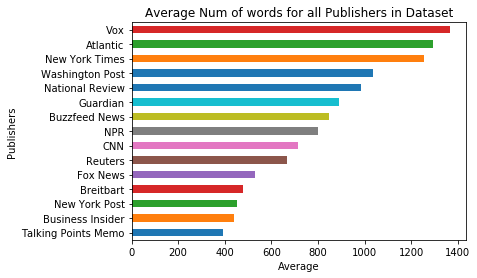

In [5]:
pubs = list(counts.keys())
means = []
for pub in pubs:
    i = 0
    sum_ = 0
    counter_ = 0
    for i in range(10000):
        if y['train'][i] == pub:
            article = X['train'][i]
            re.sub(r'\W', '', article)
            sum_ += len(article.split())
            counter_ += 1
    means.append(sum_/counter_)
    
pub_avgs = pd.Series(means, index=pubs)
pub_avgs.sort_values().plot.barh()
plt.title('Average Num of words for all Publishers in Dataset')
plt.xlabel('Average')
plt.ylabel('Publishers')

This makes a very interesting dynamic. As discussed earlier, since we might have to duplicate articles to make a uniformly distributed sample these averages say that some of the publishers with lower article counts have large word counts on average.

One point of interest is that our algorithm could potentially tell publishers a part due to article word counts.

#### Count of total number of words by each publisher

We want to do this to further know how much of an actual share each publisher has. Where the last analysis looks through the "meaty-ness" of each article, this analysis will check how much "meat" we have for each publisher.

In [6]:
from nltk.corpus import stopwords

# Stop words are high frequency yet low meaning words
# We'll remove these for the more detailed part of the analysis as they'll no doubt create tons of noise.
stop_words = stopwords.words('english')

In [7]:
%%time
i = 0
pub_total_num_words = {pub:0 for pub in pubs}
pub_total_num_words_no_stop = {pub:0 for pub in pubs}

stop_word_re = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')

for pub in y['train']:
    # Remove stop words from the counts
    doc = X['train'][i]
    
    doc_words = re.findall(r'\w+', doc)
    doc_num_words = len(doc_words)
    pub_total_num_words[pub] += doc_num_words
    
    doc = stop_word_re.sub('', doc)
    doc_words = re.findall(r'\w+', doc)
    doc_num_words = len(doc_words)
    pub_total_num_words_no_stop[pub] += doc_num_words
    i += 1

Wall time: 2min 4s


Text(0,0.5,'Publishers')

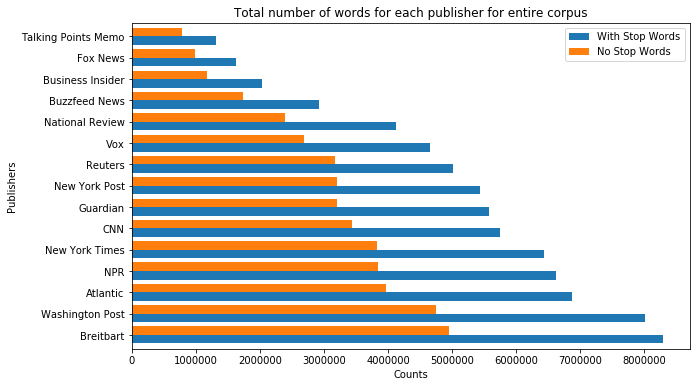

In [8]:
groups = np.array([list(pub_total_num_words.values()), list(pub_total_num_words_no_stop.values())]).transpose()
group_pubs = list(pub_total_num_words.keys())
plot_df = pd.DataFrame(groups, index=group_pubs, columns=['With Stop Words', 'No Stop Words']).sort_values('With Stop Words', ascending=False)
plot_df.plot.barh(figsize=(10, 6), width=0.8, title='Total number of words for each publisher for entire corpus')
plt.xlabel('Counts')
plt.ylabel('Publishers')

We can see that word counts aren't as uniformally distributed as we would've hoped and it could mean that our machine will begin to bias towards a publisher like Breitbart. 

> For example: our algorithm might come across a tricky article to classify, and as a last ditch effort decides the document is Breitbart out of sheer laziness because it's more likely that Breitbart will occurr.

This means that we'll potentially have more type errors (false negatives, false positives).

If it becomes too much of a problem, we could also pad out our lacking publishers with duplicate documents.

One interesting feature in the chart above is that there is a visual disparity between stop word usages, these could also be features that the algorithm will use.

Text(0,0.5,'Proportions')

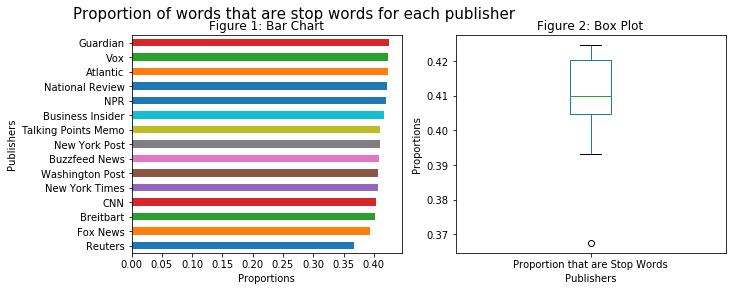

In [9]:
plot_df['Proportion that are Stop Words'] = (plot_df['With Stop Words'] - plot_df['No Stop Words'])/plot_df['With Stop Words']

plt.suptitle('Proportion of words that are stop words for each publisher', size=15)
plt.subplots_adjust(right=1.5)
plt.subplot(1,2,1)
plot_df['Proportion that are Stop Words'].sort_values().plot.barh(title='Figure 1: Bar Chart')
plt.xlabel('Proportions')
plt.ylabel('Publishers')

plt.subplot(1,2,2)
plot_df['Proportion that are Stop Words'].plot.box(title='Figure 2: Box Plot')
plt.xlabel('Publishers')
plt.ylabel('Proportions')

It appears that most publishers have similar proportions of their articles being stop words. 

However it appears that Reuters has a somewhat different proportion compared to the rest, as seen in figure 2, it is considered an outlier. This likely means that Reuters has a tendency to use more meaningful and/or descriptive words compared to the rest. But note however, it's not necessarily an indication of writing quality (as I'm not here to judge quality of writing), but could be for succintness which might be a writing trait that our algorithm could pick up on.

Let's see what cateogries most of these stop words fit into...

In [10]:
' '.join(stop_words)

"i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't"

At a glance, it seems like most of these words from `nltk` are pronouns, directional words and negation among others, and are fairly diverse. This means that we can't directly say anything about what the proportions mean.

As for the numbers, we could do a hypothesis test to test for the statistical significance of this, but it's likely that if it was, the deep learning algorithm would most likely be able to decide whether this is a contributing factor or not and it seems like it'd be worthwhile to keep it in.

However, this is a fairly interesting look at potential divergences in writing style and could potentially explain some behaviours that our algorithm will have.

#### Most frequent words for the corpus

In [11]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

# We don't want to see any stats on stop words (e.g High frequency and meaningless words)
cv = CountVectorizer(stop_words=list(stop_words))
bag_of_words = cv.fit_transform(X['train'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

Wall time: 48.2 s


In [12]:
words_freq[:15]

[('said', 400193),
 ('trump', 317249),
 ('would', 184861),
 ('one', 184651),
 ('people', 177471),
 ('new', 143567),
 ('also', 127080),
 ('like', 125794),
 ('president', 120846),
 ('time', 101618),
 ('could', 101360),
 ('clinton', 94669),
 ('first', 93084),
 ('state', 90583),
 ('two', 88879)]

It looks like a lot of these high frequency words are political, which makes sense as politics is a rather easy to report about subject and is constantly happening. These common words also suggest that most of these articles take place in a particular time frame as opposed to a spread out time frame. Suggesting that we can't use the same trained algorithm on data in a different time frame and expect similar results.

#### Most frequent words for each publisher

In [13]:
%%time

i = 0
pub_corpus = {pub:[] for pub in pubs}
for pub in y['train']:
    doc = X['train'][i]
    pub_corpus[pub].append(doc)
    i+= 1

Wall time: 733 ms


In [14]:
%%time
pub_word_freqs = {pub:None for pub in pubs}

for pub in pub_word_freqs:
    cv = CountVectorizer(stop_words=stop_words)
    bag_of_words = cv.fit_transform(pub_corpus[pub])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    pub_word_freqs[pub] = sorted(words_freq, key = lambda x: x[1], reverse=True)

Wall time: 49.3 s


In [15]:
def plot_pub_frequent_words(pub, n=12):
    counts = []
    words = []
    for word, count in pub_word_freqs[pub][:n]:
        words.append(word)
        counts.append(count)
    pd.Series(counts, index=words).plot.barh()
    plt.title(pub)
    plt.xlabel('Counts')
    plt.ylabel('Words')

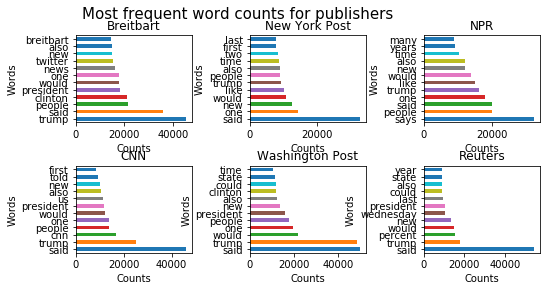

In [16]:
plot_pubs = pubs[:6]

plt.suptitle('Most frequent word counts for publishers', fontsize=15)
plt.subplots_adjust(right=1.2, wspace=0.5, hspace=0.5)
for i in range(1,7):
    plt.subplot(2,3,i)
    plot_pub_frequent_words(plot_pubs[i-1])

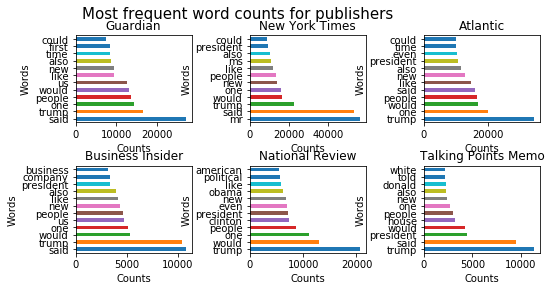

In [17]:
plot_pubs = pubs[6:12]

plt.suptitle('Most frequent word counts for publishers', fontsize=15)
plt.subplots_adjust(right=1.2, wspace=0.5, hspace=0.5)
for i in range(1,7):
    plt.subplot(2,3,i)
    plot_pub_frequent_words(plot_pubs[i-1])

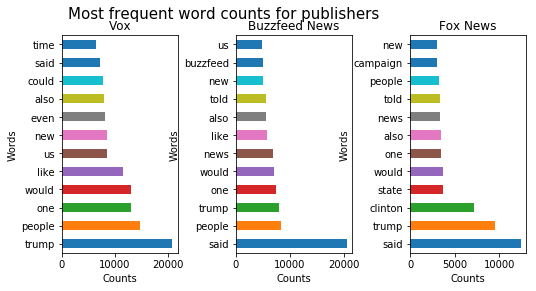

In [18]:
plot_pubs = pubs[12:15]

plt.suptitle('Most frequent word counts for publishers', fontsize=15)
plt.subplots_adjust(right=1.2, wspace=0.5, hspace=0.5)
for i in range(1,4):
    plt.subplot(1,3,i)
    plot_pub_frequent_words(plot_pubs[i-1])

The most interesting thing out of all of this is that `trump` and `said` consistently hit the first and second places of a lot of the publishers. 

We can infer writing styles based on some of these figures. Just from a glance, we can note that Vox , the Atlantic and NPS all use `don` rather than `donald`, suggesting a more casual style of writing. New York Times on the other hand, opts to use the more formal `mr`. 

Publishers are also more likely to reference themselves, with BuzzFeed and CNN all having their names as frequently used words.

This all suggests that writing style is different enough, that our algorithm might be able to pick up on it.

<a id="explain"></a>
## Explanations

Alright another data talk, before we get into cooking our meat.

I want to clear up a misconception first. If you are just starting with neural networks, they aren't as they are advertised.

#### Neural networks aren't much like the brain
    
Maybe neural networks are a rough representation of how the brain works, I don't know, but it's rather misleading to think of them that way, as one would think of them as a network of linked lists. This picture above would seems like so, but in most implementations of neural networks, they are just a series of Matrixes. 

In fact, the heart of neural networks lies in playing with matrices, we could even make a functioning (but not very efficient) neural network in Excel, [this bloke did it](https://www.youtube.com/watch?v=3993kRqejHc). (Warning: Youtube Video)

![picture](screenshots/finalreportnn2.png)
<sup>Picture drawn by draw.io</sup>

[This article is very helpful in building a neural network from scratch](https://towardsdatascience.com/build-neural-network-from-scratch-part-2-673ec7cdd89f)

#### Let me explain them further
##### Tools to help the NN learn

The neural network uses certain mathematical functions to help it decide how the weights should change. These are called **activation functions**.

***Why should we use activation functions?***

Using activation functions add degrees of **non-linearity** to the neural network. If we just let the weights flow freely as they please (or $f(x)=x$) we'll eventually just get something to this effect.

![picture](screenshots/linearnn1.png)

With this result, our neural network is more prone to underfitting with less nodes and we would need more tweaking of the amount of nodes to get an optimal result; way more than a non-linear neural network, resulting in a less efficient algorithm overall.

***Activation Functions***

The three most common are:
 - Sigmoid
 
![picture](screenshots/sigmoid.png)
 
Sigmoid is a very robust function. For every weight in the algorithm, the sigmoid function tries to force each weight into either a one or a zero, effectively giving a fundamental decision for each weight early on in the training process.

As thus, this function gives relatively fast results.
 
 - Relu
 
![picture](screenshots/relu.png)

We tend to use relu whenever sigmoid is overfitting. For example, one disadvantage of sigmoid is whenever we present data in a particular way, the algorithm will tend towards one side of the curve. 

Later on in the learning process, it might receive contradictory information, but it's mind is already set and it'll take a lot of information to change it again.

This is called the vanishing gradient problem.

 - Softmax
 
 $\sigma(z)_{j} = \frac{e^{z_{j}}}{\sum_{k=1}^Ke^{z_{k}}}, j=1,...,K$
 
Softmax is essentially the sigmoid function, except for multiple labels. The special feature of this activation function is that for every node in its layer, it'll output a number between 0 and 1, but the sum of all these outputs will equal to 1.

What this means is that if we have a layer of 2 nodes with a softmax activation, this layer will work like a sigmoid function.

For multiple-label classification tasks, this must be used as the last layer out of the other 2 present here.

In our example, out of the 15 publishers, the softmax layer will assign numbers between 0 and 1 to every publisher, we'll take the highest numbered publisher and say that that is what our neural network is predicting for that article.

***Learning Parameters***

Our NN learns by predicting and comparing that prediction with the actual values for each case, and we use that value to change every single weight, but how do we do that?

We use **loss functions**, the simplest is just $y_{actual} - y_{predicted}$. We can use that one, but in our case, due to the non-binary multiclass nature of our data, that won't even work.

We will use something more complex the big brains call **cross-entropy loss** or...

$L(y_{actual},y_{pred}) = \frac{1}{N}\sum_{n \in N}\sum_{i \in C}y_{n,i}\log y_{pred (n,i)}$

Where...
 - $N$: Training sample size

 - $C$: Number of classes

Just looking at it pains my rear side, however if we make sense of it, it essentially adds over all our predicted values, and if our NN predicted something wrong, it'll just add that to the loss function.

The more different our predictions are from their true values overall (in stats talk: the less similar these two probability distributions are), like so...

![picture](screenshots/normaldistributions.png)

The greater $L(y_{actual},y_{pred})$, our loss function will be.

For every training iteration, it'll try to decrease this loss by using an **optimizer** which tries to find the minimum of the loss function and bring it towards it.

The most popular optimizer is gradient descent, which differentiates the activation functions of each layer and then applies that to the weights of each layer.

#### Why differentiate?

![picture](screenshots/sigmoiddifferentiate.png)

Our optimiser wants to no how much to change a weight by. From the picture above, we can see that the green point (one of our weights) to the right has a less steeper line than the one to the left.

The optimiser will change the weight based on it's differentiated steepness applied with our loss function updating the weight.

#### NN procedures

 - Predicting
 - Training, which is broken up into:
    - Initialisation
    - Forward Propagation
    - Backward Propagation

#### Predicting

Say we have a neural network with 1 layer and 3 nodes for that layer.

![picture](screenshots/finalreportnn1.png)

This is essentially saying:
 - From a row from the training data...
 - Multiply that by a 1x3 matrix of weights (1 training column by 3 nodes) 
     - For every value in the matrix, apply the function of that layer (e.g. Relu)
     - Add that resulting matrix with a 1x3 (3 nodes for our hidden layer) bias matrix
     
     
 - Then multiply that result again by a 3x1 matrix or weights (3 nodes by 1 output column)
     - For every value in the matrix, apply the function of that layer (e.g. Sigmoid)
     - Add that resulting matrix with a 1x1 (1 node for our output) bias matrix
 - And that resulting column is our prediction (but since we have 1 output node, it's just a number)

#### Initialisation

For initialisation, we create matrices of random numbers, our later stages will correct any errors that our random numbers may have.

In our case above, we would create a random matrix of 1x3 for our 1st weights, and 3x1 random matrix for our 2nd weights.

#### Forward Propagation (FP)

FP just executes the prediction stage. 

This time however, the machine compares the results from this prediction and records the difference between the prediction and the actual value.

#### Backward Propagation (BP)

The algorithm now goes backwards and updates each value based on what the loss function and optimiser is.

To train, the neural network just forward and backward propagates any given amounts of time that we want it to.


### Further tools to be used

Text in it's raw string form can't be processed by most machine learning algorithms, they need them to be converted into more mathematical representations of words. 

So how do we make text understandable by our machine?

We could order all words in our training set into a simple list of words, and then for each article, we could count the amount of times each word appears. This method is called count vectorising which is a part of a greater group of text handling methods called the bag of words approach.

These methods, though fast, have glaring issues, namely:

- **It can't account for word position.**
    - "Bad restaurant with good parking" will be counted as equivalent to "Good restaurant with bad parking". We know these two sentences aren't saying the same thing. 
    <sup>(even though they'll provide similar customer experiences in the end anyway)</sup>

- **It can't account for plurals.**
    - It'll see "apples" as having completely no relation to "apple" even though we know that can't be the case

- **It can't account for synonyms.**
    - "King", "Sultan", "Tsar" or "Emperor" what does it matter right?

- **It can't account for different word meanings in the same word**
    - "Apple" the company vs. "apple" the... apple.
    
We can allieviate all of this by using...

### Word Embeddings

![picture](screenshots/finalreportembeddings.jpg)

The embeddings that we use are called Word2Vec which is a combination of 2 methods, namely the continuous bag of words approach and the skip-gram model. These are neural networks which effectively does what our count vectoriser does, except it takes into account the probabilities of word occurances given the context and the context given a word, respectively. 

##### In a nutshell...

Word2Vec is a neural network that is trained for a list of words however, this time, we aren't interested in the results, we want the weights.

But in order to get to the weights we want, we have to give it a goal. This goal is question is:

Given a word in a sentence (or our input word):
1. Pick one of the either words on its side.
2. Give us the probability for every word in our vocabulary of being close to that word (or `n` words away from that word)

In order to train this algorithm, we'll feed it pairs of words (or bi-grams) from sentences, so essentially the NN gets the statistics from the number of times each pairing shows up and it essentially learns a probability from these statistics.

##### Denutshelled...

So how is this all represented?

We have to make it machine readable first and to do this we have to count vectorise, except instead of assigning a number, we just assign 1 if the word is present in the article, this is called one-hot encoding.

We’re going to represent an input word like "apple" as a one-hot vector. This vector will have, let's say 1000 rows (one for every word in our vocabulary) and we’ll place a "1" in the position corresponding to the word "apple", and 0s in all of the other positions.

The output of the network is a single vector (also of size 1000) which has the probability that a randomly selected nearby word is close to "apple" in our sentence.

This is what it'll look like as a pretty picture...

![picture](screenshots/finalreportembedexplain.png)

When we get to use Word2Vec, essentially we'll use the Word2Vec as a lookup table and extract the values (or coefficients) corresponding to the words in the lookup table and use those as probabilities given contexts.

##### Great! So.... What does this all mean?

Effectively, words that have similar contexts will output similar results for these words.

So that means that words like, "queen" and "royal" will have very similar vector values.

This makes for a very **powerful** tool as it can get to know synonyms, differences in meanings in the same word, and can also handle things like plurals of objects. 

It accounts for the negatives of traditional bag of words approaches explained above.

## Baseline

We'll start with a simple model first to see how well we'll do.

In [12]:
model = Sequential()
model.add(Embedding(input_dim=len(words), 
                    output_dim=4, 
                    input_length=input_length))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              # Ouch, I messed up here, be sure to use 'accuracy'
              metrics=['categorical_crossentropy']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1500, 4)           1049592   
_________________________________________________________________
flatten_3 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                90015     
Total params: 1,139,607
Trainable params: 1,139,607
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time
model.fit(enc_X['train'], enc_y['train'], epochs=16, batch_size=16)

Epoch 1/16
99799/99799 [==============================] - 136s 1ms/step - loss: 1.5679 - categorical_crossentropy: 1.5679
Epoch 2/16
99799/99799 [==============================] - 136s 1ms/step - loss: 1.0205 - categorical_crossentropy: 1.0205
Epoch 3/16
99799/99799 [==============================] - 135s 1ms/step - loss: 0.8465 - categorical_crossentropy: 0.8465
Epoch 4/16
99799/99799 [==============================] - 140s 1ms/step - loss: 0.7394 - categorical_crossentropy: 0.7394
Epoch 5/16
99799/99799 [==============================] - 142s 1ms/step - loss: 0.6638 - categorical_crossentropy: 0.6638
Epoch 6/16
99799/99799 [==============================] - 141s 1ms/step - loss: 0.6136 - categorical_crossentropy: 0.6136
Epoch 7/16
99799/99799 [==============================] - 143s 1ms/step - loss: 0.5713 - categorical_crossentropy: 0.5713
Epoch 8/16
99799/99799 [==============================] - 139s 1ms/step - loss: 0.5374 - categorical_crossentropy: 0.5374
Epoch 9/16
99799/99799 [

In [14]:
%%time
def model_split_f1_scores(include_test=False):
    from sklearn.metrics import f1_score

    y_pred_probs = {key:model.predict(enc_X[key]) 
                    for key in parts}
    
    y_pred = {key:np.argmax(y_pred_probs[key], axis=1) 
              for key in parts}

    y_actual = {key:np.argmax(enc_y[key], axis=1) 
                for key in parts}
    
    f1 = {key:f1_score(y_actual[key], y_pred[key], average='weighted') 
          for key in parts}
    
    for key in f1:
        if include_test == False and key == 'test':    
            continue
        print('%s:\t%.2f' % (key, f1[key]))
        
    return f1

model_split_f1_scores(include_test=True)

train:	0.97
dev:	0.71
test:	0.71
Wall time: 4.53 s


{'dev': 0.7112389451793275,
 'test': 0.7065433453057208,
 'train': 0.9723803388891158}

Not bad, with a score of training `0.97` to validation `0.71`, however, there is a clear sign of overfitting which we definitely want to try to even out.

<a id="try"></a>
## Let's try to fix it!

Whilst we can train Word2Vec, we want to try to use [GloVe's embeddings](https://www.google.com.au/search?q=glove+embeddings&oq=glove+embedding&aqs=chrome.0.0j69i57j0l4.3351j0j4&sourceid=chrome&ie=UTF-8), made by the folks at Stanford. We want to use this as it's a general all purpose embedding which doesn't require training; we just load it in, and it does it's job.

Let's look how the information is displayed line by line...

```
meissnitzer 0.34976 0.91903 0.59415 0.91344 0.70594 ...
```

By the looks of things, it seems like we just need to:
1. Take the line
2. Convert it into a python list
3. Take the first element [0] and record it as a dictionary entry
4. Take every other entry and put it as the dictionary entry's definition

Let's get cracking!

In [3]:
# Reading the GloVe embedding matrix and converting it into something we can work with easily
glove_vect = {}
vect_len = 50
with open('data/word2vec/glove.6B.'+str(vect_len)+'d.txt', encoding='utf-8') as file:
    for line in file:
        row = line.split()
        word = row[0]
        coefs = np.array(row[1:])
        glove_vect[word] = coefs
len(glove_vect)

399999

Now we want to represent our articles in a way that our neural network may understand it.

We do this by assigning words numbers from 1 to the total number of unique words + 1 (Words assigned to 0 will be skipped by Keras, for example, if the machine ever comes across a word it doesn't know, it'll assign it to zero)

In [4]:
%%time
input_length = 1500 

# Enc stands for encoding
enc_y = {}
enc_X = {}

print("Fitting label encoder...")
# LabelEncoder assigns one class to a number
# E.g. Fox News = 0, Vox = 1 etc.
le = LabelEncoder()
le.fit(y['train'])

print("Fitting X tokeniser...")
"""
    Essentially, our tokenizer assigns almost arbitrary numbers to our words
    "Fit" learns which word to assign to which number
    "Transform" applies what it learnt in "fit" to a given article
"""
token = Tokenizer()
token.fit_on_texts(X['train'])

# Records all words that were learnt by our tokenizer
token_words = token.word_index

print("Encoding...")
"""
    1) le.transform: Applies "transform" to all publishers for every document
    2) to_categorical: Turns the numbers for each publisher into a 1 by 15 array
    where 2 = 001000... and 6 = 00000010...

    This is so it can be fed into the machine like a cube into a square hole
"""
enc_y = {key:to_categorical(le.transform(y[key]))
         for key in parts}

"""
    In principle, does the same thing except with all unique words in all the articles

    pad_sequences: ensures all articles are of word length exactly 1500, 
    <1500 will get 0's added onto the end, 
    >1500 will simple get the rest of the words cut
    We chose 1500 because that's around the size of the largest articles
"""
enc_X = {key:np.array(pad_sequences(
    token.texts_to_sequences(X[key]), 
    maxlen=input_length, padding='post')) 
         for key in parts}

Fitting label encoder...
Fitting X tokeniser...
Encoding...
Wall time: 2min 53s


Here, we want to create our Keras friendly matrix.

The matrix has to be made in a way so that the tokenizer's numbers match up with GloVe.

This is so that, say we convert the word "beer" into a number by our tokenizer, our embedding matrix will correctly match it to the entry of "beer".

In [5]:
%%time
embed_mat = np.zeros((len(token_words)+1, vect_len))
i = 0

for word in token_words:
    # It appears that our data has a lot of ASCII characters that aren't filterable
    # So this line of code uses regex to clean the words of bad characters
    word_clean = re.sub('\W', '', word)
    try:
        embed_vect = glove_vect[word_clean]
    except KeyError as KE: 
        # If the GloVe matrix doesn't recognise the word,                
        # then we just assign it a random number for simplicity
        embed_vect = np.random.normal(size=vect_len)
    finally:
        embed_mat[token_words[word]] = embed_vect
        i += 1

Wall time: 8.16 s


Let see if our vectors matched up correctly.

In [6]:
foo = X['train'][0].split()[0]
foo

'New'

In [7]:
glove_vect[foo.lower()][:10]

array(['0.19511', '0.50739', '0.0014709', '0.041914', '-0.16759',
       '0.037517', '-1.397', '-0.92398', '-0.24296', '-0.15171'],
      dtype='<U9')

In [8]:
bar = token_words[foo.lower()]
bar

55

In [9]:
embed_mat[bar][:10]

array([ 0.19511  ,  0.50739  ,  0.0014709,  0.041914 , -0.16759  ,
        0.037517 , -1.397    , -0.92398  , -0.24296  , -0.15171  ])

Looks all good!

Let's fire up the machine!

In [10]:
"""
    The embedding matrix must be presented so that the GloVe embedding may fit in snuggly
    And that the tokenizer recognises which word should go into which index
"""
embed = Embedding(
    # INPUT_DIM: are all the indexes for our words + 1
               # +1 to allow for a zero for unknown/unrecognised words
    input_dim=len(token_words)+1, 
    
    # OUTPUT_DIM: are the vector lengths from our GloVe matrix 
                # for each individual word
    output_dim=vect_len, 
    
    # INPUT_LENGTH: How long each article will be
                #   This has to be a fixed value so that we can do matrix multiplications easily
    input_length=input_length,
    
    # Finally, our GloVe embedding matrix.
    weights=[embed_mat])

"""
    Note: Before, I tried setting the embedding to be untrainable
          However this gave me at most, a 0.5 prediction accuracy on my training set
          
          I also tried an initial baseline with a completely trained-from-scratch embedding
          However this overfitted by 0.99 (training) to 0.79 (validation) 
          
          So we know from experience that our publishers are distinct enough 
          that the algorithm would be able to know the differences
"""
# embed.trainable = False

"""
    Start a model template, Sequential means that our model will go in a left to right order, 
    Some neural networks may go in other directions
"""
model = Sequential()

""" 
    2) Add the embedding matrix
"""
model.add(embed)

"""
    3) Average each word's result from the embedding matrix
        # We do this so that we play with only 1 dimension not 2
        # Essentially, this averages all the "words" together 
        # to give us the average value for the document
"""
model.add(Lambda(lambda x: K.mean(x, axis=1)))

""" 
    4) Dropout(0.4) randomly blocks 40% of all outputted indexes for every step
        # This is so that we can potentially avoid overfitting
"""
model.add(Dropout(0.4))

"""
    5) Our neural network is essentially just a softmax layer after the embedding
        # Softmaxes are needed for multiple classes
        # e.g. to decide for 15 publishers
"""
model.add(Dense(15, activation='softmax'))

"""
    This function prepares our algorithm for training
    Before we train, we must state what metric it should train by
    
    CATEGORICAL_CROSS...: Measures how far our predictions are from the actual prediction, 
                          this value is higher the further away from the correct predictions we are
                          
                          Our algorithm during training will try to decrease this value,
                          but if it's rate of decrease slows down, EarlyStopping will halt the training
    
    ADAM_OPTIMISER: A combination of various other optimisers,
                    Optimisers try to pull the neural network's 
                    weights to a decisive value during training.
                    
                    In our case, our optimizer at a basic level, 
                    finds the derivative of our softmax layer and 
                    pulls the weights towards a decision.
    
    ACC: Accuracy, just how accurate our predictions are.
                          
"""
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, mode='min')]
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 50)          20168800  
_________________________________________________________________
lambda_1 (Lambda)            (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                765       
Total params: 20,169,565
Trainable params: 20,169,565
Non-trainable params: 0
_________________________________________________________________


As we can see in our model summary above. We have **20,199,365** cells in matrices that we have to compute for.

In [11]:
model.fit(enc_X['train'], enc_y['train'], 
          validation_data=[enc_X['dev'], enc_y['dev']], 
          epochs=128, batch_size=256, callbacks=callbacks)

Train on 99799 samples, validate on 21386 samples
Epoch 1/128
99799/99799 [==============================] - 205s 2ms/step - loss: 2.5018 - acc: 0.1853 - val_loss: 2.3381 - val_acc: 0.2256
Epoch 2/128
99799/99799 [==============================] - 217s 2ms/step - loss: 2.2969 - acc: 0.2615 - val_loss: 2.2027 - val_acc: 0.3067
Epoch 3/128
99799/99799 [==============================] - 215s 2ms/step - loss: 2.1604 - acc: 0.3211 - val_loss: 2.0645 - val_acc: 0.3671
Epoch 4/128
99799/99799 [==============================] - 213s 2ms/step - loss: 2.0268 - acc: 0.3756 - val_loss: 1.9311 - val_acc: 0.4161
Epoch 5/128
99799/99799 [==============================] - 215s 2ms/step - loss: 1.8989 - acc: 0.4233 - val_loss: 1.8064 - val_acc: 0.4647
Epoch 6/128
99799/99799 [==============================] - 216s 2ms/step - loss: 1.7814 - acc: 0.4626 - val_loss: 1.6924 - val_acc: 0.5010
Epoch 7/128
99799/99799 [==============================] - 217s 2ms/step - loss: 1.6701 - acc: 0.4992 - val_loss: 1.

In [12]:
# You don't have to do this, 
# I just wanted to save my model in case my computer sneezes
model.save('models/FinalReportModel.h5')

from keras.models import load_model
model = load_model('models/FinalReportModel.h5')

Now as our articles aren't particularly balanced for all publishers, we want to see the precision and recall, this'll give us an idea of where our model is failing. 

In [43]:
y_pred = model.predict(enc_X['test'])
enc_y['pred'] = to_categorical(y_pred.argmax(axis=1))
model.evaluate(enc_X['test'], enc_y['test'])

21385/21385 [==============================] - 4s 182us/step


[0.5140901908630352, 0.8494739303277814]

At `0.93`, `0.85`, even though there is some slight overfitting, it is a noticeable improvement from our `0.97`, `0.71` result from our baseline.

<a id='discussion'></a>
## Discussion and Evaluation

### Why did training a pretrained Word2Vec work better for us?

Most probably due to the fact that using a pretrained Word2Vec helped get rid of the initial randomness of the non-trained Word2Vec. 

![picture](screenshots/finalreportpretrained.png)

As we can see in my beautifully drawn picture, the curve represents the overall loss function of the entire neural network. The red dots being randomly assigned neural network values all have to work their ways individually to their local minimums. 

However the green dots (our pre-trained matrix) will use the information from GloVe's training (which had more data to draw from and more epoches to train, and thus be better fit generally) to be a little closer to the global minimum than randomly instantiated Word2Vec. 

The general-ness of the information in the pre-trained matrix will also help the algorithm to over-fit less compared to our randomly instantiated Word2Vec.

### Issues with our architecture

Our architecture itself might benefit from some more layers with varied activation functions attached to it.

Right now, our model is essentially a multi-classed regression that is fed by Word2Vec. We aren't using neural networks to their full potential.

Adding some more hidden layers gives it some non-linearity that our current model probably suffers from.

### General analysis of results

We want to create a confusion matrix to see how well we did over all the publishers.

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

cm = confusion_matrix(enc_y['test'].argmax(axis=1), enc_y['pred'].argmax(axis=1))

The following was sourced from the smart folk at scikit learn itself, [over here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [71]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False, verbose=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if verbose:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


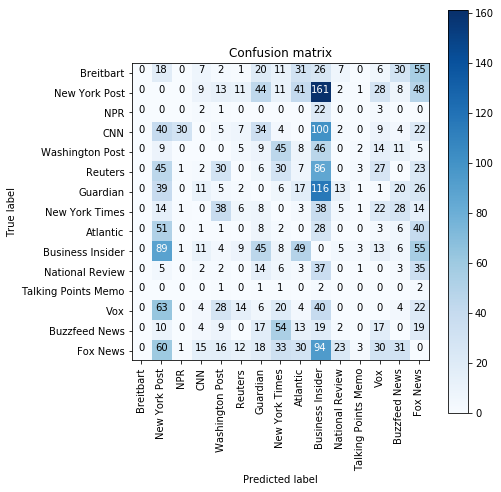

In [74]:
"""
    I want to get rid of all diagonal values, as they are the values that are correct, 
    we don't want those. We want to see what went wrong
"""
i = 0
ct = cm
for arr in ct:
    arr[i] = 0
    i += 1
ct

plt.figure(figsize=(7,7))
plot_confusion_matrix(ct, normalize=False, classes=pubs)

In the confusion matrix, we can see that there are a lot of articles being incorrectly predicted to be from Business Insider, which is not what we expected from the data analysis. A glance back at the data analysis shows that Business Insider doesn't have a large share of the data.

But a look at the similarities of frequent words between Business Insider and New York Post show that there is a slight overlap between the choice of vocabulary between these two publishers.

On the other hand, Fox News shows the most variation in either writing style or subject matter as both articles that are meant to be Fox are being predicted wrongly and vice versa.

We can check the rate of how they are doing.

Text(0,0.5,'Publishers')

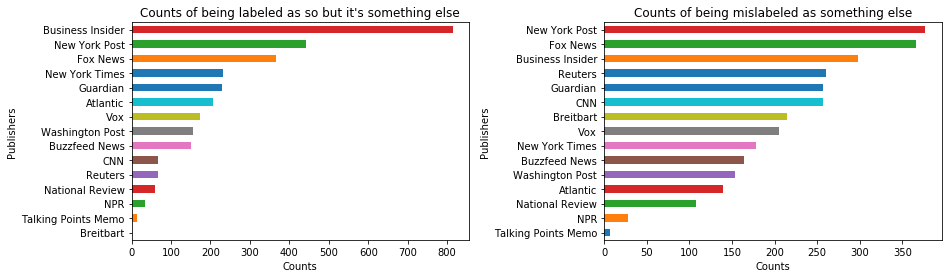

In [93]:
plt
plt.subplots_adjust(right=2, wspace=0.4)
plt.subplot(121)
pd.Series(ct.sum(axis=0),index=pubs).sort_values().plot.barh(title='Counts of being labeled as so but it\'s something else')
plt.xlabel('Counts')
plt.ylabel('Publishers')
plt.subplot(122)
pd.Series(ct.sum(axis=1),index=pubs).sort_values().plot.barh(title='Counts of being mislabeled as something else')
plt.xlabel('Counts')
plt.ylabel('Publishers')

The counts of Business Insider is definitely creating issues for our machine to further learn. The machine tends to pick Business Insider above the rest, as it also sits high within the counts of being mislabeled as something else.

Overall, there some glaring issues with the data and our algorithm...

- Publishers who write in more generic writing styles and wider subject matters may get confused with each other, smaller subtleties might not be picked up yet.
- The data isn't timeless. As most publishers would try to concertrate their articles onto the bigger events, many of the more generic publishers will eventually write in the same style using the same vocabulary. In this case, a concerntration onto the most recent US elections has caused most publishers to concerntrate on particular words.
- The diversity of writers is not noted down, for some publishers, there might only be one writer, for others, there might be many, and it's not noted whether or not one could be working for multiple publishers. 
- We don't take into account the sentiment of the articles. With the sentiment, the algorithm might be able to slowly understand the general opinion of the publisher.

With this model, we first and foremost took into account the subject matter and the usage of vocabulary of the articles with the embedding matrix. If we wanted a better predictive model, it would be best to utilise more features, rather than purely text. 

That's simply the main issue with our model, we just don't have enough data to make a very good NLP model.